<a href="https://colab.research.google.com/github/fereidoon27/sample-colab/blob/main/result_compare_analyze_gp_7CWP_AFCLA_rank0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://github.com/fereidoon27/jaxalpha.git

In [2]:
%%capture
# Install required packages
!pip install biopython matplotlib scipy py3Dmol

# Import required libraries
import sys
!{sys.executable} -m pip install biopython matplotlib scipy py3Dmol

In [3]:
import sys
from io import StringIO

def capture_and_save_output(func):
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            result = func(*args, **kwargs)
            output = sys.stdout.getvalue()
        finally:
            sys.stdout = old_stdout

        with open('/content/result_compare_analyze.txt', 'a') as f:
            f.write(f"Output of {func.__name__}:\n")
            f.write(output)
            f.write("\n\n")

        print(output)
        return result
    return wrapper

import IPython

ip = IPython.get_ipython()
ip.run_cell = capture_and_save_output(ip.run_cell)

In [4]:
# Import required libraries
from Bio import PDB
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

# Load PDB files
parser = PDB.PDBParser()
query_structure = parser.get_structure("query", "/content/ranked_0.pdb")
correct_structure = parser.get_structure("correct", "/content/jaxalpha/org_pdb_AF/7CWP/Cor_str.pdb")

#print("Structures loaded successfully")

# Calculate RMSD
def calculate_rmsd(struct1, struct2):
    atoms1 = [atom for atom in struct1.get_atoms() if atom.name == 'CA']
    atoms2 = [atom for atom in struct2.get_atoms() if atom.name == 'CA']

    if len(atoms1) != len(atoms2):
        print("Warning: Structures have different number of CA atoms")
        return None

    coords1 = np.array([atom.coord for atom in atoms1])
    coords2 = np.array([atom.coord for atom in atoms2])

    # Calculate RMSD
    diff = coords1 - coords2
    return np.sqrt(np.sum(diff**2) / len(coords1))

rmsd_value = calculate_rmsd(query_structure[0], correct_structure[0])
print(f"RMSD between query and correct structure: {rmsd_value:.2f} Å")

# RMSD measures the average distance between corresponding atoms in two superimposed protein structures.
# Lower RMSD values indicate higher structural similarity.

RMSD between query and correct structure: 0.80 Å



In [5]:
# Note: TM-score calculation is complex and typically requires external tools.
# Here's a simplified version that approximates TM-score:

def simplified_tm_score(struct1, struct2):
    atoms1 = [atom for atom in struct1.get_atoms() if atom.name == 'CA']
    atoms2 = [atom for atom in struct2.get_atoms() if atom.name == 'CA']

    if len(atoms1) != len(atoms2):
        print("Warning: Structures have different number of CA atoms")
        return None

    d0 = 1.24 * (len(atoms1) - 15) ** (1/3) - 1.8

    distances = []
    for a1, a2 in zip(atoms1, atoms2):
        distance = np.linalg.norm(a1.coord - a2.coord)
        distances.append(1 / (1 + (distance / d0) ** 2))

    return sum(distances) / len(atoms1)

tm_score = simplified_tm_score(query_structure[0], correct_structure[0])
print(f"Simplified TM-score: {tm_score:.4f}")

# TM-score ranges from 0 to 1, where 1 indicates a perfect match.
# Scores > 0.5 generally indicate the same fold, while scores < 0.2 indicate random structural similarity.

Simplified TM-score: 0.9740



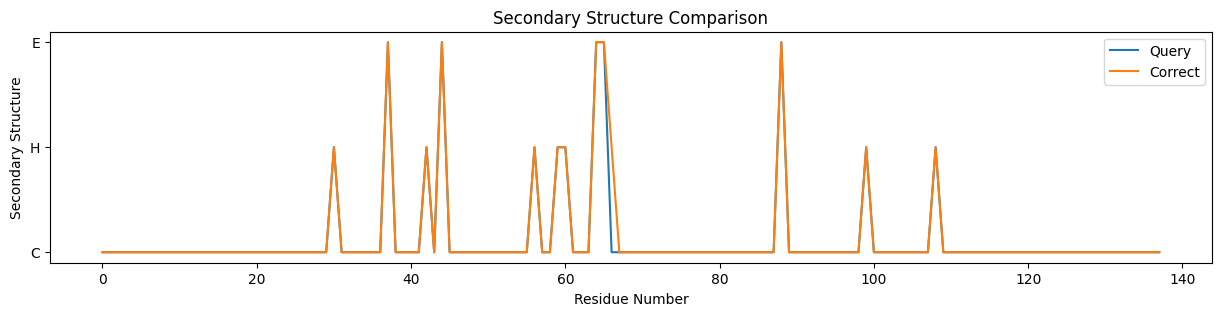

Secondary structure similarity: 99.28%



In [6]:
# Simplified secondary structure estimation
def estimate_secondary_structure(structure):
    ca_atoms = [atom for atom in structure.get_atoms() if atom.name == 'CA']
    ss = []
    for i in range(1, len(ca_atoms) - 1):
        v1 = ca_atoms[i-1].coord - ca_atoms[i].coord
        v2 = ca_atoms[i+1].coord - ca_atoms[i].coord
        angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        if angle < 90:
            ss.append('H')  # Helix-like
        elif angle > 140:
            ss.append('E')  # Sheet-like
        else:
            ss.append('C')  # Coil
    return ''.join(['C'] + ss + ['C'])  # Add 'C' to start and end

query_ss = estimate_secondary_structure(query_structure[0])
correct_ss = estimate_secondary_structure(correct_structure[0])

# Calculate percentage of matching secondary structure elements
matching_ss = sum(q == c for q, c in zip(query_ss, correct_ss))
ss_similarity = (matching_ss / len(query_ss)) * 100

print(f"Secondary structure similarity: {ss_similarity:.2f}%")

# Plot secondary structure comparison
plt.figure(figsize=(15, 3))
plt.plot(list(query_ss), label='Query')
plt.plot(list(correct_ss), label='Correct')
plt.legend()
plt.title('Secondary Structure Comparison')
plt.xlabel('Residue Number')
plt.ylabel('Secondary Structure')
plt.savefig('/content/1.png')
plt.show()



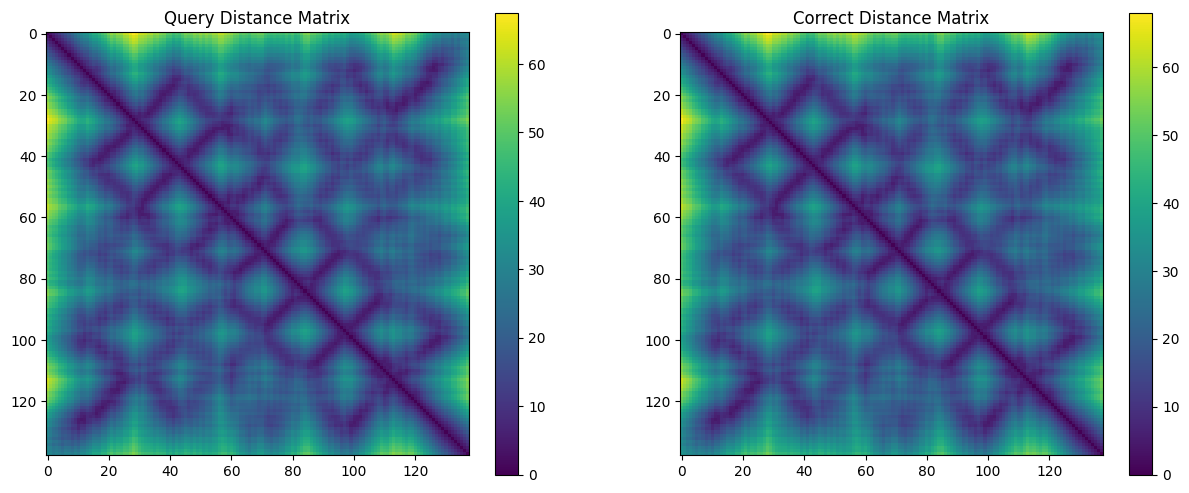

In [7]:
def calculate_distance_matrix(structure):
    atoms = [atom for atom in structure.get_atoms() if atom.name == 'CA']
    coords = np.array([atom.coord for atom in atoms])
    return np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)

query_dist_matrix = calculate_distance_matrix(query_structure[0])
correct_dist_matrix = calculate_distance_matrix(correct_structure[0])

# Plot distance matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.imshow(query_dist_matrix, cmap='viridis')
ax1.set_title('Query Distance Matrix')
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(correct_dist_matrix, cmap='viridis')
ax2.set_title('Correct Distance Matrix')
fig.colorbar(im2, ax=ax2)
plt.savefig('/content/2.png')
plt.show()

# Distance matrices represent pairwise distances between all residues in a protein.
# Similar patterns in the distance matrices indicate similar overall protein folds.

In [8]:
def visualize_structures(struct1, struct2):
    view = py3Dmol.view(width=800, height=400)

    # Add first structure
    pdb1 = PDB.PDBIO()
    pdb1.set_structure(struct1)
    pdb1.save("temp1.pdb")
    with open("temp1.pdb") as f:
        view.addModel(f.read(), "pdb")
    view.setStyle({'model': 0}, {"cartoon": {'color': 'blue'}})

    # Add second structure
    pdb2 = PDB.PDBIO()
    pdb2.set_structure(struct2)
    pdb2.save("temp2.pdb")
    with open("temp2.pdb") as f:
        view.addModel(f.read(), "pdb")
    view.setStyle({'model': 1}, {"cartoon": {'color': 'red'}})

    view.zoomTo()
    view.show()

visualize_structures(query_structure, correct_structure)

# Visual comparison allows for a qualitative assessment of structural similarities and differences.
# Blue represents the query structure, while red represents the correct structure.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
import numpy as np
from Bio import PDB

def calculate_gdt_ts(struct1, struct2, cutoffs=[1, 2, 4, 8]):
    """
    Calculate GDT-TS (Global Distance Test - Total Score) for two protein structures.

    :param struct1: First protein structure (Biopython Structure object)
    :param struct2: Second protein structure (Biopython Structure object)
    :param cutoffs: List of distance cutoffs in Angstroms
    :return: GDT-TS score (0 to 100)
    """
    # Get CA atoms from both structures
    atoms1 = [atom for atom in struct1.get_atoms() if atom.name == 'CA']
    atoms2 = [atom for atom in struct2.get_atoms() if atom.name == 'CA']

    if len(atoms1) != len(atoms2):
        raise ValueError("Structures have different numbers of CA atoms")

    # Calculate distances between corresponding CA atoms
    distances = []
    for a1, a2 in zip(atoms1, atoms2):
        distance = np.linalg.norm(a1.coord - a2.coord)
        distances.append(distance)

    # Calculate the percentage of atoms within each cutoff
    percentages = []
    for cutoff in cutoffs:
        within_cutoff = sum(1 for d in distances if d <= cutoff)
        percentage = (within_cutoff / len(distances)) * 100
        percentages.append(percentage)

    # Calculate GDT-TS
    gdt_ts = sum(percentages) / len(cutoffs)

    return gdt_ts

# Load structures
parser = PDB.PDBParser()
query_structure = parser.get_structure("query", "/content/ranked_0.pdb")
correct_structure = parser.get_structure("correct", "/content/jaxalpha/org_pdb_AF/7CWP/Cor_str.pdb")

# Calculate GDT-TS
gdt_ts = calculate_gdt_ts(query_structure[0], correct_structure[0])

print(f"GDT-TS score: {gdt_ts:.2f}")

# Interpretation of GDT-TS score
if gdt_ts > 50:
    print("The predicted structure is likely to have the correct fold.")
elif gdt_ts > 30:
    print("The predicted structure may have some structural similarity.")
else:
    print("The predicted structure is likely to be incorrect.")

GDT-TS score: 96.38
The predicted structure is likely to have the correct fold.



In [10]:
# Import necessary libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the file path
file_path = "/content/jaxalpha/result_model_pkl_gp/7CWP/result_model_1_pred_0.pkl"

# Load the .pkl file
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Print the keys of the dictionary to understand its structure
print('keys of the dictionary pickle : ', data.keys())


keys of the dictionary pickle :  dict_keys(['distogram', 'experimentally_resolved', 'masked_msa', 'predicted_lddt', 'structure_module', 'plddt', 'ranking_confidence'])



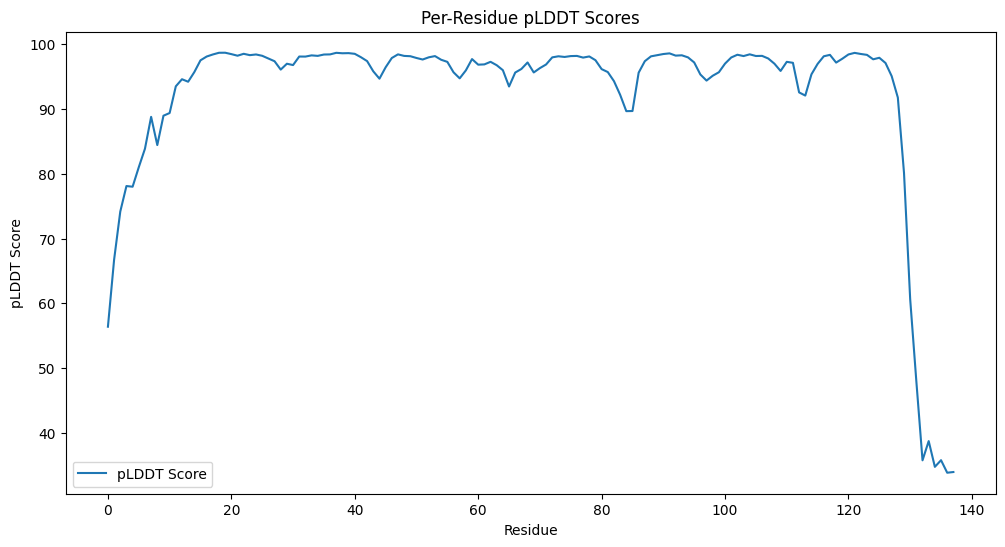

In [11]:
# Extract pLDDT scores
plddt_scores = data['plddt']

# Plot the pLDDT scores
plt.figure(figsize=(12, 6))
plt.plot(plddt_scores, label='pLDDT Score')
plt.xlabel('Residue')
plt.ylabel('pLDDT Score')
plt.title('Per-Residue pLDDT Scores')
plt.legend()
plt.savefig("/content/Per_Residue_pLDDT_Scores.png")
plt.show()

# Explanation:
# This plot shows the confidence score for each residue.
# Higher scores (closer to 100) indicate higher confidence in the model's prediction for that residue.


In [12]:
%%capture
!zip -j /content/result_compare_analyze_gp.zip /content/result_compare_analyze.txt /content/1.png /content/2.png /content/Per_Residue_pLDDT_Scores.png


In [13]:
from google.colab import files
files.download('/content/result_compare_analyze_gp.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>